In [1]:
import os
import numpy as np

import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
import pycuda.autoinit
from tensorrt.parsers import onnxparser
import tensorrt as trt

In [2]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.INFO)

class Profiler(trt.infer.Profiler):
    """
    Example Implimentation of a Profiler
    Is identical to the Profiler class in trt.infer so it is possible
    to just use that instead of implementing this if further
    functionality is not needed
    """
    def __init__(self, timing_iter):
        trt.infer.Profiler.__init__(self)
        self.timing_iterations = timing_iter
        self.profile = []

    def report_layer_time(self, layerName, ms):
        record = next((r for r in self.profile if r[0] == layerName), (None, None))
        if record == (None, None):
            self.profile.append((layerName, ms))
        else:
            self.profile[self.profile.index(record)] = (record[0], record[1] + ms)

    def print_layer_times(self):
        totalTime = 0
        for i in range(len(self.profile)):
            print("{:40.40} {:4.3f}ms".format(self.profile[i][0], self.profile[i][1] / self.timing_iterations))
            totalTime += self.profile[i][1]
        print("Time over all layers: {:4.3f}".format(totalTime / self.timing_iterations))

In [3]:
MODEL_FILE_PATH = "/home/chen2/amaris/model/cat_dog_epo39/model.onnx"

In [4]:
# Create onnx_config
apex = onnxparser.create_onnxconfig()
apex.set_model_file_name(MODEL_FILE_PATH)
apex.set_model_dtype(trt.infer.DataType.FLOAT)
apex.set_print_layer_info(True) # Optional debug option

# create parser
trt_parser = onnxparser.create_onnxparser(apex)
assert(trt_parser)
data_type = apex.get_model_dtype()
onnx_filename = apex.get_model_file_name()
trt_parser.parse(onnx_filename, data_type)
trt_parser.report_parsing_info()
trt_parser.convert_to_trtnetwork()
trt_network = trt_parser.get_trtnetwork()
assert(trt_network)

In [5]:
# create infer builder
trt_builder = trt.infer.create_infer_builder(G_LOGGER)
trt_builder.set_max_batch_size(1)
trt_builder.set_max_workspace_size(1 << 20)

if (apex.get_model_dtype() == trt.infer.DataType_kHALF):
    trt_builder.set_half_2mode(True)
elif (apex.get_model_dtype() == trt.infer.DataType_kINT8):
    msg = "Int8 Model not supported"      
    G_LOGGER.log(trt.infer.Logger.Severity_kERROR, msg)
print("----- Builder is Done -----")
print("----- Creating Engine -----")
trt_engine = trt_builder.build_cuda_engine(trt_network)
print("----- Engine is built -----")

----- Builder is Done -----
----- Creating Engine -----
----- Engine is built -----


In [6]:
def create_memory(engine, name,  buf, mem, batchsize, inp, inp_idx):
    binding_idx = engine.get_binding_index(name)
    print('binding index: ', binding_idx)
    if binding_idx == -1:
        raise AttributeError("Not a valid binding")
    print("Binding: name={}, bindingIndex={}".format(name, str(binding_idx)))
    dims = engine.get_binding_dimensions(binding_idx).to_DimsCHW()
    eltCount = dims.C() * dims.H() * dims.W() * batchsize

#     if engine.binding_is_input(binding_idx):
#         h_mem = inp[inp_idx]
#         print("h_mem: ", h_mem)
#         inp_idx = inp_idx + 1
#     else:
#         h_mem = np.random.uniform(0.0, 255.0, eltCount).astype(np.dtype('f4'))

    h_mem = 
    d_mem = cuda.mem_alloc(eltCount * 4)
    cuda.memcpy_htod(d_mem, h_mem)
    buf.insert(binding_idx, int(d_mem))
    mem.append(d_mem)
    return inp_idx, mem

def get_input_output_names(trt_engine):
    nbindings = trt_engine.get_nb_bindings();
    maps = []

    for b in range(0, nbindings):
        dims = trt_engine.get_binding_dimensions(b).to_DimsCHW()
        name = trt_engine.get_binding_name(b)
        type = trt_engine.get_binding_data_type(b)
        
        if (trt_engine.binding_is_input(b)):
            maps.append(name)
            print("Found input: ", name)
        else:
            maps.append(name)
            print("Found output: ", name)

        print("shape=" + str(dims.C()) + " , " + str(dims.H()) + " , " + str(dims.W()))
        print("dtype=" + str(type))
    return maps

SyntaxError: invalid syntax (<ipython-input-6-b37cd5b55431>, line 17)

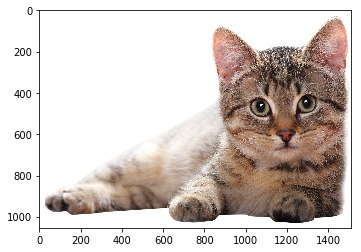

In [10]:
# image_url = "http://farm1.static.flickr.com/55/133241226_5509add812.jpg"

# import urllib, cStringIO
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow 

# file = cStringIO.StringIO(urllib.urlopen(image_url).read())
#ImageFile.LOAD_TRUNCATED_IMAGES = True
#img = np.asarray(Image.open(file))
#img = img.resize( (224, 224), Image.NEAREST )

file = os.path.join('/home/chen2/amaris/data/cat_dog/test','cat.png')
img = Image.open(file)
%matplotlib inline
imshow(np.asarray(img))
img = np.asarray(img)
img = img.astype(np.float32)

In [12]:
OUTPUT_SIZE = 2
BATCH_SIZE = 1

input = img.astype(np.float32)
output = np.empty(OUTPUT_SIZE, dtype = np.float32)
d_input = cuda.mem_alloc(1 * input.size * input.dtype.itemsize)
d_output = cuda.mem_alloc(1 * output.size * output.dtype.itemsize)

bindings = [int(d_input), int(d_output)]
cuda.memcpy_htod(d_input, input)
trt_context = trt_engine.create_execution_context()
trt_context.execute(BATCH_SIZE, bindings)

cuda.memcpy_dtoh(output, d_output)

In [13]:
print("output index: ", np.argmax(output))
print("accuracy:", output[np.argmax(output)])

('output index: ', 905)
('accuracy:', 0.3413155)


In [14]:
# # Inference time
# bindings = []
# mem = []
# inp_idx = 0
# batch_size = 1
# inp = "/home/chen2/amaris/data/bvlc_googlenet/test_data_set_0/input_0.pb"


# print(trt_engine.get_nb_bindings())

# for io in get_input_output_names(trt_engine):
#     print('io: ', io)
#     inp_idx, mem = create_memory(trt_engine, io,  bindings, mem, batch_size, inp, inp_idx)

# output = np.empty(OUTPUT_SIZE, dtype = np.float32)

# trt_context = trt_engine.create_execution_context()
# #g_prof = Profiler(100)
# #trt_context.set_profiler(g_prof)
# #for i in range(iter):
# trt_context.execute(batch_size, bindings)
# #g_prof.print_layer_times()

# print(np.argmax(output))

# #print(inp_idx)
# #print(mem)

trt_parser.destroy()
trt_network.destroy()
trt_context.destroy()
trt_engine.destroy()
trt_builder.destroy()